# 심층학습 (Deep Learning)
## 실습04 심층신경망 훈련 - CIFAR10 인식 정확도 챌린지 (중간 대체 과제)
### 201810793 이연우

### 구글 드라이버와 연결하기

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### CIFAR10을 CNN 으로 학습하기. 여러 학습 방법으로 비교

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
from tqdm import tqdm

#learning rate decay
from torch.optim import lr_scheduler

batch_size = 16
learning_rate = 0.002
num_epoch = 120 # 100번이상 해야지 제대로 학습됨, 어느정도 효과있는지 확인을 위해 1만

### 1. CIFAR 10 train, test dataset 가져오기 (163 MB)
MNIST : 11MB

In [3]:
#cifar_train = dset.CIFAR10("CIFAR10/",train = True, transform = transforms.ToTensor(), target_transform = None, download = True)
#cifar_test = dset.CIFAR10("CIFAR10/",train = False, transform = transforms.ToTensor(), target_transform = None, download = True)

#(2) Data augmentation
# 위의 두 줄 주석
'''
# train 데이터 set을 불리는 효과, test 데이터셋에서는 하지 않는다.
cifar_train=dset.CIFAR10("CIFAR10/",train=True, 
                        transform=transforms.Compose([
                            #transforms.Scale(36), # 36만큼 키운다음
                            #transforms.CenterCrop(32), # 32만큼 크롭
                            transforms.RandomHorizontalFlip(), # 수평, 가로 방향으로 반전
                            transforms.Lambda(lambda x: x.rotate(1)), # 90도 회전
                            transforms.ToTensor()]))
                            # 투투렌스폼을 포함해서 위와 같은것들을 해달라
                            # 로딩할때마다 위를 적절히 섞어서 Data augmentation을 해줌
cifar_test = dset.CIFAR10("CIFAR10/",train = False, transform = transforms.ToTensor(), target_transform = None, download = True)


#(4) Data Normalization
'''
# 맨 위의 두 줄 주석
# train할 때도 test할때도 Data Normalization을 한다.
cifar_train=dset.CIFAR10("CIFAR10/",train=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5,0.5,0.5),std= (0.2,0.5,0.8)),
                            ])
                         ,target_transform=None,download=True)
cifar_test=dset.CIFAR10("CIFAR10/",train=False,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5,0.5,0.5),std= (0.2,0.5,0.8)),
                        ])
                         ,target_transform=None,download=True)



Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10/
Files already downloaded and verified


### 2. 대략적인 데이터 형태

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cifar_train 길이: 50000
cifar_test 길이: 10000
image data 형태:  torch.Size([3, 32, 32])
label:  0


<function matplotlib.pyplot.show>

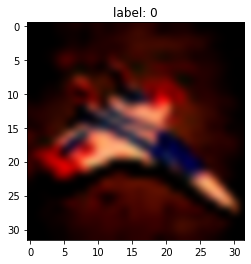

In [4]:
print ("cifar_train 길이:",len(cifar_train))
print ("cifar_test 길이:",len(cifar_test))

# 데이터 하나 형태
image, label = cifar_train.__getitem__(30) #30번째 데이터
print ("image data 형태: ",image.size()) # [채널수, W, H], RGB = 3채널)
print ("label: ", label)

#그리기
img=image.numpy() #image 타입을 numpy로 변환(3, 32, 32)

#(3,32,32)->(32,32,3) # 채널을 뒤로 옮겨야함
r,g,b=img[0,:,:],img[1,:,:],img[2,:,:]

#img=img.reshape(img.shape[1],img.shape[2],img.shape[0])
img2=np.zeros((img.shape[1],img.shape[2],img.shape[0]))
img2[:,:,0],img2[:,:,1],img2[:,:,2]=r,g,b

plt.title("label: %d" %label)
plt.imshow(img2,interpolation='bicubic')
plt.show

In [5]:
def ComputeAccr(dloader, imodel):
    correct=0
    total=0
    
    for j, [imgs,labels] in enumerate(dloader): #batch_size 만큼
        img=Variable(imgs,volatile=True).cuda() #x
        #label=Variable(labels) #y
        label=Variable(labels).cuda()
        #.cuda(): GPU에 로드되기 위함, 만약 CPU로 설정되어 있다면 에러남
        
        output=imodel.forward(img)#forward prop.
        _, output_index=torch.max(output,1)
        
        total+=label.size(0)
        correct+=(output_index==label).sum().float()
    print("Accuracy of Test Data: {}".format(100*correct/total))

In [6]:
# == 3.데이터 로드함수 ==
train_loader=torch.utils.data.DataLoader(list(cifar_train)[:],batch_size=batch_size,shuffle=True,num_workers=2,drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test,batch_size=batch_size,shuffle=False,num_workers=2,drop_last=True)

# == 4.모델 선언 ==
class CNN(nn.Module): # week7 기준 배우지 않았으니 보기만
    def __init__(self):
        super(CNN,self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(3,16,3,padding=1),
            nn.PReLU(),
            #nn.Dropout2d(0.25), #(1)drop out 
            nn.BatchNorm2d(16), #(5) Batch normalization
            nn.Conv2d(16,32,3,padding=1),
            nn.PReLU(),
            #nn.Dropout2d(0.25),
            nn.BatchNorm2d(32), 
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1),
            nn.PReLU(),
            nn.Dropout2d(0.5), 
            nn.BatchNorm2d(64), 
            nn.MaxPool2d(2,2)
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*8*8, 64*4*4),
            nn.PReLU(),
            nn.Dropout2d(0.5), 
            nn.BatchNorm1d(64*4*4),
            nn.Linear(64*4*4, 64*2*2),
            nn.PReLU(),
            nn.Dropout2d(0.5),
            nn.BatchNorm1d(64*2*2),
            nn.Linear(64*2*2, 10),
        )
    # (3) weight initialization
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                init.kaiming_normal_(m.weight.data) # RELU일 때
                m.bias.data.fill_(0)
            if isinstance(m,nn.Linear):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
       
    def forward(self,x):
        out=self.layer(x)
        out=out.view(batch_size,-1)
        out=self.fc_layer(out)
        
        return out
model=CNN().cuda()

In [7]:
# == 5. loss, optimizer ==
loss_func=nn.CrossEntropyLoss()
#optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate) #(6)Adam optimizer, 위에 주석

# epoch를 1이 아닌 60,100 정도로 해야함(오래걸림)
#num_epoch = 60
schedule=lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1) #(7)learning rate decay

model.train() 
'''
학습 시키는 부분
# == 6. 학습 ==
for i in tqdm (range(num_epoch)):
    print(" %d 번째~" %i)
    for j,[image,label] in enumerate(train_loader):
        #for j, [image, label] in tqdm(enumerate(train_loader)):
       
        x = Variable(image).cuda()
        y_=Variable(label).cuda()
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss=loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
        if j%1000==0:
           print(j,loss)
'''
model.eval()

CNN(
  (layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): PReLU(num_parameters=1)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): PReLU(num_parameters=1)
    (9): Dropout2d(p=0.5, inplace=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Dropout2d(p=0.5, inplace=False)
   

## 학습된 파라미터 불러오기

In [8]:
netname = './gdrive/MyDrive/201810793_Model.pkl'
model = torch.load(netname) #로드 가져오기
ComputeAccr(test_loader,model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 82.69999694824219
